In [56]:
import tensorflow as tf
from qiskit import *
from qiskit.providers.ibmq import *
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

import time
from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# import keras
from tensorflow.keras.models import Sequential#,Input,Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow import keras
# from keras_layer_normalization import BatchNormalization
# from keras_layer_normalization import LayerNormalization
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [57]:
def clear_dataset(df, n_qubits):
    df = df.drop_duplicates()
    for i in range(n_qubits):
        df = df.drop('measure_' + str(i), axis=1)
    #Rimozione Features non interessanti
    df = df.drop('N_measure', axis = 1)
    # remove edges which are not in coupling maps
    # connections = ['01','10','12','21','13','31','35','53','45','54','56','65']
    connections = []
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    provider.backends(simulator=False)
    if n_qubits == 7:
        backend = provider.get_backend('ibm_nairobi')
        coupling_map = IBMQBackend.configuration(backend).to_dict()['coupling_map']
        for tup in coupling_map:
            connections.append(str(tup[0])+str(tup[1]))
    else:
        backend = provider.get_backend('ibm_brisbane')
        coupling_map = IBMQBackend.configuration(backend).to_dict()['coupling_map']
        for tup in coupling_map:
            connections.append(str(tup[0])+str(tup[1]))
    print("Connections:",connections)
    to_keep = []
    for c in connections:
        to_keep.append("edge_error_"+c)    
        to_keep.append("edge_length_"+c)
    to_drop = []
    for c in df.columns:
        if "edge_error" in c or "edge_length" in c:
            if c not in to_keep:
                to_drop.append(c)
    df = df.drop(to_drop,axis=1)
    return df

In [58]:
num_qubits = 7
# df = pd.read_csv("dataset/dataset_tesi/NN1_Dataset(\uf03c=10Cx)_balanced1.csv")
df = pd.read_csv("dataset/dataset_tesi/NN1_Dataset(<=10Cx)_balanced1.csv")

data_to_use = int(1*len(df))
df = df.iloc[:data_to_use]
df = clear_dataset(df, num_qubits)
df

ibmqfactory.load_account:WARNING:2023-11-24 14:59:19,601: Credentials are already in use. The existing account in the session will be replaced.


Connections: ['01', '10', '12', '13', '21', '31', '35', '45', '53', '54', '56', '65']


,Unnamed: 0,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,0,2023-07-06 13:10:36-07:00,ibm_lagos,7,53,6,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,4,5,6
1,1,2023-07-06 13:10:36-07:00,ibm_lagos,7,40,2,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,4,5,6
2,2,2023-07-06 13:10:36-07:00,ibm_lagos,7,23,2,0,0,0,0,...,44.734718,92.600073,0.0137,0,1,2,3,4,5,6
3,3,2023-07-06 13:10:36-07:00,ibm_lagos,7,37,3,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,6,5,4
4,4,2023-07-06 14:11:03-07:00,ibm_perth,7,73,4,0,0,0,0,...,234.956902,240.488458,0.0090,0,1,2,3,4,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,8892,2023-07-19 14:53:52-07:00,ibm_perth,7,18,7,0,0,0,0,...,254.488154,313.822759,0.0087,0,1,2,3,4,5,6
8893,8893,2023-07-19 14:42:36-07:00,ibm_nairobi,7,48,4,0,0,0,0,...,109.585360,141.228784,0.0256,2,1,0,3,6,5,4
8894,8894,2023-06-07 15:11:48-07:00,ibm_lagos,7,86,7,0,0,0,0,...,161.383544,104.767721,0.0144,2,1,0,3,4,5,6
8895,8895,2023-06-07 14:34:17-07:00,ibm_perth,7,33,2,0,0,0,0,...,175.573329,244.762409,0.0073,0,1,2,3,4,5,6


In [59]:
last_num_qubits = len(df.columns)-num_qubits
labels = df.iloc[:, last_num_qubits:].values
"""
Node fatures: T1, T2,readout_error (N*3)
Edge features: CNOTs, edge_error, edge_length ((edges*3))
edge_features -> ((t1_i,t2_i,readout_i),(t1_j,t2_j,readout_j),(edge_error_ij,edge_length_ij,cnot_ij))

"""
X,X_ev = [],[]
for i in tqdm(range(len(df))):
    edge_features = []
    for edge_i in range(num_qubits):
        for edge_j in range(num_qubits):
            if edge_i != edge_j:
                cx = df["cx_"+str(edge_i)+str(edge_j)][i]
                edge_error, edge_length  = 100000, 100000
                if "edge_error_"+str(edge_i)+str(edge_j) in df.columns:
                    edge_error = df["edge_error_"+str(edge_i)+str(edge_j)][i]
                    edge_length = df["edge_length_"+str(edge_i)+str(edge_j)][i]
                
                t1_i = df["T1_"+str(edge_i)][i]
                t2_i = df["T2_"+str(edge_i)][i]
                readout_i = df["readout_error_"+str(edge_i)][i]
            
                t1_j = df["T1_"+str(edge_j)][i]
                t2_j = df["T2_"+str(edge_j)][i]
                readout_j = df["readout_error_"+str(edge_j)][i]
                
                
                edge_features.append(np.array([t1_i,t2_i,readout_i,t1_j,t2_j,readout_j,cx,edge_error,edge_length]))
    X.append(np.array(edge_features).flatten())
X = np.array(X)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8897/8897 [00:07<00:00, 1225.79it/s]


In [60]:
X.shape, X[0].shape

((8897, 378), (378,))

In [74]:
y_old =(df.iloc[:, last_num_qubits:].values)
y = []
for i in range(len(y_old)):
    n = len(y_old[i])
    y_new = np.array(([[0]*n]*n))
    for j in range(len(y_old[i])):
        y_new[j][y_old[i][j]] = 1
    y_new = y_new.flatten()
    y.append(y_new)
    
y=np.array(y)

# y = np.array(y_old)
y.shape



(8897, 49)

In [84]:
# X = df.iloc[:, 3:last_num_qubits].values
SS = StandardScaler()
X_st = SS.fit_transform(X)
#MS = MinMaxScaler()
#X_st = MS.fit_transform(X)

#Building validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.10, random_state=1)

In [85]:
def build_model(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(input_shape//2,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2 = Dense(input_shape//4,kernel_initializer='uniform',activation='relu')(layer1)
        layer3 = Dense(49,kernel_initializer='uniform',activation='relu')(layer2)
        merged = Model(inputs=[input_layer], outputs=[layer3])

        return merged
    
    
    
def build_model_y_7(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(input_shape//2,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2 = Dense(input_shape//4,kernel_initializer='uniform',activation='relu')(layer1)
        layer3 = Dense(input_shape//8,kernel_initializer='uniform',activation='relu')(layer2)
        layer4 = Dense(input_shape//16,kernel_initializer='uniform',activation='relu')(layer3)
        layer5 = Dense(7,kernel_initializer='uniform',activation='relu')(layer4)
        merged = Model(inputs=[input_layer], outputs=[layer5])

        return merged
    
def build_model_original_df(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(70,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2= Dense(49,kernel_initializer='uniform',activation='relu')(layer1)
        merged = Model(inputs=[input_layer], outputs=[layer2])

        return merged
    
def build_model_original_df_y_7(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(70,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2= Dense(49,kernel_initializer='uniform',activation='relu')(layer1)
        layer3= Dense(25,kernel_initializer='uniform',activation='relu')(layer2)
        layer4= Dense(12,kernel_initializer='uniform',activation='relu')(layer3)
        layer5= Dense(7,kernel_initializer='uniform',activation='relu')(layer4)
        
        merged = Model(inputs=[input_layer], outputs=[layer5])

        return merged

# model = build_model(X[0].shape[0])
# model = build_model_y_7(X[0].shape[0])
model = build_model_original_df(X[0].shape[0])
# model = build_model_original_df_y_7(X[0].shape[0])
model.build(X[0].shape[0])
# model.compile(loss='mean_squared_error',optimizer='adam')
# learning_rate = 0.01
learning_rate = 0.0005
optimizer = tf.optimizers.Adam(name='Adam', learning_rate=learning_rate)
model.compile(
  optimizer=optimizer,
  loss='mean_squared_error',
  metrics=[tf.keras.metrics.mean_squared_error])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 89)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 70)                6300      
_________________________________________________________________
dense_25 (Dense)             (None, 49)                3479      
Total params: 9,779
Trainable params: 9,779
Non-trainable params: 0
_________________________________________________________________


In [86]:
X[0].shape[0]//32

2

In [87]:
start = time.time()
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=125,
    validation_split=0.15,
    verbose=1)
end = time.time()
print("Time taken to train the model:", end-start)
print(history.history.keys())

Epoch 1/125
14/14 [==============================] - 0s 3ms/step - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1283 - val_mean_squared_error: 0.1283
Epoch 2/125
14/14 [==============================] - 0s 2ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1086 - val_mean_squared_error: 0.1086
Epoch 3/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0977 - mean_squared_error: 0.0977 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 4/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 5/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 6/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 7/125
14/14 [===============

14/14 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 52/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 53/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 54/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 55/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 56/125
14/14 [==============================] - 0s 2ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 57/125
14/14 [=====================

14/14 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 102/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 103/125
14/14 [==============================] - 0s 2ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 104/125
14/14 [==============================] - 0s 2ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 105/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 106/125
14/14 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 107/125
14/14 [===============

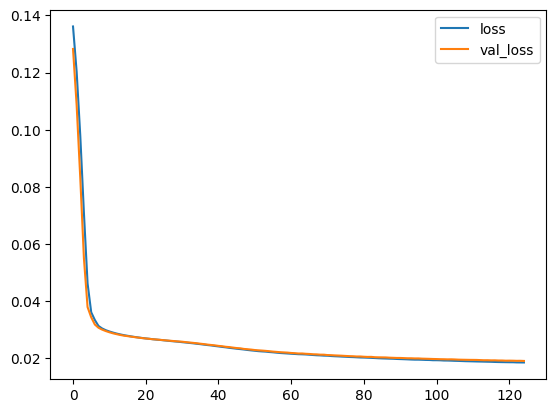

In [88]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'] , label = "loss")
plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")


plt.legend()
plt.show()

In [89]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

In [83]:
# count = 0
# for i in range(len(train_pred)):
#     actual=y_train[i].tolist()
#     predicted=np.round(train_pred[i]).astype(int).tolist()
#     print(actual,predicted)
#     if actual == predicted:
#         count = count + 1
        
# print("Train accuracy:",count/len(train_pred))

# count = 0
# for i in range(len(test_pred)):
#     actual=y_test[i].tolist()
#     predicted=np.round(test_pred[i]).astype(int).tolist()
#     if actual == predicted:
#         count = count + 1
        
# print("Test accuracy:",count/len(test_pred))

In [90]:
def get_labels(y):
    labels = []
    for i in range(len(y)):
        labels.append(np.where(y[i]==np.max(y[i]))[0][0])
#         for j in range(len(y[i])):
#             if y[i][j] != 0:
#                 labels.append(j)
                
    return labels

count = 0
for i in range(len(train_pred)):
    actual=get_labels(np.reshape(y_train[i],(7,7)))
    predicted=get_labels(np.reshape(train_pred[i],(7,7)))
#     print(actual)
#     print(predicted)
#     print("---------------------------")
    if actual == predicted:
        count = count + 1
        
print("Train accuracy:",count/len(train_pred))

Train accuracy: 0.8219058323966529


In [91]:
count = 0
for i in range(len(test_pred)):
    actual=get_labels(np.reshape(y_test[i],(7,7)))
    predicted=get_labels(np.reshape(test_pred[i],(7,7)))
#     print(actual)
#     print(predicted)
#     print("---------------------------")
    if actual == predicted:
        count = count + 1
        
print("Test accuracy:",count/len(test_pred))

Test accuracy: 0.8247191011235955


In [ ]:
Train accuracy: 0.8652429124516049
Test accuracy: 0.8662921348314607


In [39]:
import os
os.listdir("dataset/dataset_tesi")

['NN1_Dataset(\uf03c=10Cx)_balanced1.csv',
 'NN1_Dataset(\uf03c=10Cx)_balanced1_with_sabre.csv']